# TP1 Least Mean Squares


## Imports de librerias

In [1]:
!pip install pyroomacoustics

In [52]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import scipy.io.wavfile as wav
from IPython.display import Audio
import pyroomacoustics as pra #hay que instalar

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Definición de clases


In [4]:
class VSNLMS:
	def __init__(self, mu, mu_max, mu_min, m0, m1, alpha, delta=0.0):
		"""
		Funcion de inicialización del algoritmo VSNLMS
		@:param mu: Coeficiente de ajuste de paso inicial
		@:param mu_max: Maximo valor del coeficiente de paso (Los coeficientes se van ajustando a medida que se hacen
		iteraciones por el algoritmo VS-LMS)
		@:param mu_min: Mínimo valor del coeficiente de paso
		@:param m0_per: Cantidad de valores de gradiente que deben cambiar de signo para que se ajuste el mu. Esta cantidad
		viene dada porcentualmente del valor de N
		@:param m1_per: Cantidad de valores de gradiente que deben mantener signo para que se ajuste el mu. Esta cantidad
		viene dada porcentualmente del valor de N
		@:param alpha: parametro de ajuste del mu
		@:param delta: delta del algoritmo NLMS, esta puesto para asegurar que en el caso de que el denominador sea nulo no
		explote.
		"""
		self.mu = mu
		self.count_mu_values = 0
		self.mu_max = mu_max
		self.mu_min = mu_min
		self.alpha = alpha
		self.m0 = m0
		self.m1 = m1
		self.prev_sign = 0
		self.delta = delta
		self.prev_grad = []
		return

	def calcNewCoef(self, a_n, signal, error):
		"""
		Funcion que dados unos coeficientes previos, los actualiza correspondientemente
		:param a_n: Coeficientes a actualizar
		:param signal: Vector de señal de entrada
		:param error: Valor del error para actualizar los coeficientes
		:return: Vector de coeficientes actualizados formateados de la misma manera que a_n
		"""
		grad = np.array(signal) * error
		if len(self.prev_grad) != 0:
			if np.sum(np.sign(grad) != self.prev_grad) > self.m0 and self.mu > self.mu_min:
				self.mu /= self.alpha
			elif np.sum(np.sign(grad) == self.prev_grad) > self.m1 and self.mu < self.mu_max:
				self.mu *= self.alpha
		self.prev_grad = np.sign(grad)
		return a_n + self.mu * grad / (np.dot(signal, signal) + self.delta)  # NLMS

	def getMu(self):
		"""
		Funcion para obtener el mu actual del algoritmo
		:return: mu actual.
		"""
		return self.mu

In [5]:
class AdaptativeFilter:
	def __init__(self, N, mu=1e-3, mu_max=1.1, mu_min=1e-9, m0_per=0.9, m1_per=0.9, alpha=10, delta=0.0):
		"""
		Funcion de inicializacion del filtro adaptativo
		@:param N: Es el orden del filtro
		@:param mu: Coeficiente de ajuste de paso inicial
		@:param mu_max: Maximo valor del coeficiente de paso (Los coeficientes se van ajustando a medida que se hacen
		iteraciones por el algoritmo VS-LMS)
		@:param mu_min: Mínimo valor del coeficiente de paso
		@:param m0_per: Cantidad de valores de gradiente que deben cambiar de signo para que se ajuste el mu. Esta cantidad
		viene dada porcentualmente del valor de N
		@:param m1_per: Cantidad de valores de gradiente que deben mantener signo para que se ajuste el mu. Esta cantidad
		viene dada porcentualmente del valor de N
		@:param alpha: parametro de ajuste del mu
		@:param delta: delta del algoritmo NLMS, esta puesto para asegurar que en el caso de que el denominador sea nulo no
		explote.
		"""
		self.N = N
		self.w = np.random.randn(N)
		self.mu = mu
		m0 = m0_per * N
		m1 = m1_per * N
		self.vsnlms = VSNLMS(self.mu, mu_max, mu_min, m0, m1, alpha, delta)
		self.inp_signal = list(np.zeros(N))
		self.err = 1
		return

	def fit(self, input, desired):
		"""
		Funcion que actualiza los pesos de un filtro adaptativo para que se ajusten a la respuesta deseada.
		@:param input: Vector de entrada al filtro adaptativo
		@:param desired: Vector de señal deseada del filtro adaptativo.
		"""
		self.inp_signal = list(np.zeros(self.N))
		self.err = 1
		for x, d in tqdm(zip(input, desired)):
			self.inp_signal.append(x)
			self.inp_signal.pop(0)
			self.err = d - np.dot(self.inp_signal, self.w)  # Esta definido de esta manera
			self.updateLMS()
		return

	def getFilterParameters(self):
		"""
		Función que devuelve los parámetros del filtro adaptativo
		@:return Los coeficientes del filtro
		"""
		return np.flip(self.w)

	def updateLMS(self):
		"""
		Función que actualiza los coeficientes del filtro adaptativo, utiliza los vectores self.inp_signal, sel.w, y el valor
		self.err
		"""
		self.w = self.vsnlms.calcNewCoef(self.w, self.inp_signal, self.err)
		return

	def getMu(self):
		"""
		Devuelve el Mu actual del filtro adaptativo
		@:return mu Actual
		"""
		return self.vsnlms.getMu()

	def applyFilterSame(self, input):
		"""
		Aplica el filtro adaptativo obtenido a un vector de entrada
		@:param input: vector de entrada para aplicar el filtro. (IMPORTANTE: No actualiza self.inp_signal)
		@:return Vector de salida del filtro.
		"""
		return signal.convolve(input, np.flip(self.w), mode="same")  # No esta chequeado que vaya el modo same

	def applyFilterFull(self, input):
		"""
		Aplica el filtro adaptativo obtenido a un vector de entrada
		@:param input: vector de entrada para aplicar el filtro. (IMPORTANTE: No actualiza self.inp_signal)
		@:return Vector de salida del filtro.
		"""
		return signal.convolve(input, np.flip(self.w), mode="full")  # No esta chequeado que vaya el modo same

	def resetInput(self):
		"""
		Función que borra los datos de self.inp_signal y los setea todos en cero
		"""
		self.inp_signal = list(np.zeros(self.N))
		return

	def applyFilterToTap(self, tap):
		"""
		Funcion que aplica el filtro adaptativo a un solo tap de entrada, utiliza los valores previos guardados en self.inp_signal
		y actualiza ese vector (IMPORTATNE: Actualiza los valores de self.inp_signal)
		@:param tap: Valor del tap de entrada a aplicar el filtro
		@:return Valor de salida del filtro adaptativo
		"""
		self.inp_signal.append(tap)
		self.inp_signal.pop(0)
		temp = self.applyFilterFull(self.inp_signal)
		temp2 = temp[self.N - 1]
		return temp2

	def fitFilterWithErrorTap(self, input_vector, e_tap):
		"""
		Funcion que actualiza los valores de los coeficientes del filtro adaptativo dado un tap de señal de error.
		(IMPORTANTE: La señal self.inp_signal debe estar previamente actualizada al tap de entrada correspondiente a e_tap).
		@:param input_vector: Vector de entrada al filtro para actualizar los coeficientes
		@:param e_tap: Es un tap de la señal de error medida.
		"""
		self.err = e_tap
		self.w = self.vsnlms.calcNewCoef(self.w, input_vector, self.err)
		return

	def fitFilterWithDesired(self,d_tap):
		"""
		Funcion que actualiza los coeficientes del filtro con un tap actual de la señal deseada
		(IMPORTANTE: self.inp_signal debe estar previamente cargada con el tap de entrada actual).
		:param d_tap: tap de la señal deseada
		"""
		self.err = d - np.dot(self.inp_signal, self.w)
		self.updateLMS()
		return

	def setInputVector(self, input):
		"""
		Funcion que setea el input vector desde afuera.
		:param input: Vector de input para actualizar el filtro adaptativo
		"""
		if len(input) != self.N:
			raise Exception(f"No coinciden el tamaño del filtro {self.N} con el input vector metido {len(input)}")
		self.inp_signal = input
		return

In [6]:
class Filter:
	def __init__(self,coefs):
		"""
		Funcion para inicializar el filtro con una lista de coeficientes dada
		:param coefs: Coeficientes del filtro a inicializar deben estar dados de la siguiente manera:
			[w0,w1,w2,w3,..wN]
		"""
		self.coefs = coefs
		return

	def applyFilter(self, input):
		"""
		Funcion para aplicar el filtro a una señal de entrada dada
		:param input: Vector de señal de entrada, con el valor mas reciente ubicado a derecha, y el valor mas viejo a
		izquierda.
		:return: Vector de la señal de salida, filtrada.
		"""
		return signal.convolve(input, self.coefs, mode="full")

	def getFilterLen(self):
		"""
		Funcion que devuelve la cantidad de parámetros del filtro.
		:return:
		"""
		return len(self.coefs)

	def getCoefs(self):
		"""
		Funcion que devuelve una lista con los coeficientes del filtro.
		:return: Lista con los coeficientes del filtro.
		"""
		return self.coefs

## Simulación


Definición de los Filtros $S_2$ y $P$

Definición del filtro $S_2$

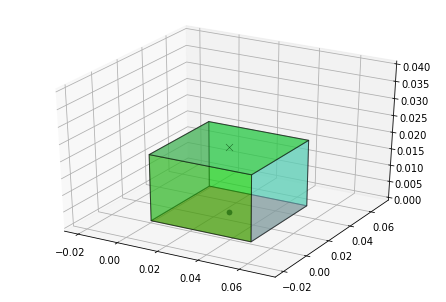

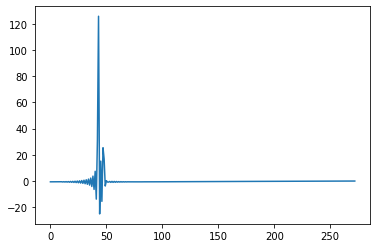

In [7]:
#fs, signal = wav.read("/content/o_white.wav")
x = np.random.randn(999999)
fs = 48e3
m = pra.make_materials(ceiling=0.3,
                       floor=0.3,
                       east=0.8,
                       west=0.8,
                       north=0.8,
                       south=0.8,)

room_dim = [0.05, 0.05, 0.02]
room = pra.ShoeBox(room_dim, fs=fs, materials=m, air_absorption=True, ray_tracing=True)

#set_raytracing
room.add_source([0.025, 0.025, 1e-4], signal=x)
mike = np.array([0.025, 0.025, 0.02-1e-4])
room.add_microphone(mike)
fig, ax = room.plot(mic_marker_size=50)
ax.set_xlim([-0.025, 0.025 + 0.05])
ax.set_ylim([-0.025, 0.025 + 0.05])
ax.set_zlim([0, 0.04])
plt.show()

#room.set_ray_tracing(receiver_radius=0.5, n_rays=10000, energy_thres=1e-5)
room.image_source_model()

room.compute_rir()
plt.plot(room.rir[0][0])

response = room.rir[0][0] #respuesta impulsiva
#print(room.rir[0][0])
#print(len(room.rir[0][0]))

In [8]:
s2 = Filter(list(response[:60]/np.max(response)))

In [ ]:
#t = np.linspace(0,-10,6)
#signs = np.array([(-1)**n for n in range(6)])
#temp = np.power(np.e,t)*signs
#temp /= np.sum(temp)
#s2 = Filter(temp)

Definición del filtro $P$

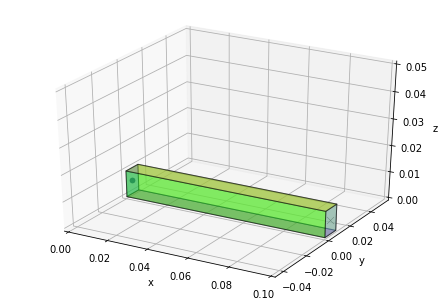

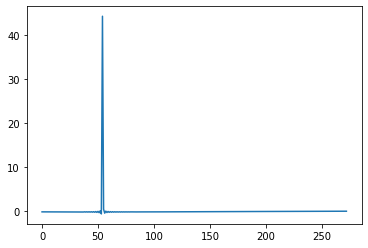

In [89]:
x = np.random.randn(999999)
fs = 48e3
m = pra.make_materials(ceiling=0.3,
                       floor=0.3,
                       east=0.8,
                       west=0.8,
                       north=0.8,
                       south=0.8,)

room_dim = [0.1, 0.01, 0.01]
room = pra.ShoeBox(room_dim, fs=fs, materials=m, air_absorption=True, ray_tracing=True)

#set_raytracing
room.add_source([1e-4, 0.005, 0.005], signal=x)
mike = np.array([0.1-1e-4, 0.005, 0.005])
room.add_microphone(mike)
fig, ax = room.plot(mic_marker_size=50)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.set_xlim([0, 0.1])
ax.set_ylim([-0.045, 0.055])
ax.set_zlim([0, 0.05])
plt.show()

#room.set_ray_tracing(receiver_radius=0.5, n_rays=10000, energy_thres=1e-5)
room.image_source_model()

room.compute_rir()
plt.plot(room.rir[0][0])

response = room.rir[0][0] #respuesta impulsiva

In [88]:
p = Filter(list(response[0:60]/np.max(response)))

In [ ]:
#t = np.linspace(0,-10,30)
#signs = np.array([(-1)**n for n in range(30)])
#temp = np.power(np.e,t)*signs
#temp /= np.sum(temp)
#p = Filter(temp)

Realizo la estimación del filtro $S_2$ con 100000 muestras de ruido blanco gaussiano. Esto lo hago enviando al parlante las muestras de ruido blanco gaussiano y midiendo cuanto mide el microfono de error.


In [55]:
filter_size = 60
# 1ro Envio al parlante Ruido Blanco gaussiano y mido cuando me mide el error mic
muestras = 100000
wgn = np.random.randn(muestras)
error_mic = s2.applyFilter(wgn)
s2_estimation = AdaptativeFilter(60, 1e-2, 1, 1e-20, 1, 1, 10, 1e-5)
# Obtengo la estimacion del filtro S2
s2_estimation.fit(wgn, error_mic)

Aca se observa como el filtro estimó perfectamente los primeros 4 elementos del filtro $S_2$

In [56]:
print(s2.getCoefs()[0:4])
print(s2_estimation.getFilterParameters()[0:4])

[-0.004828807111537319, -0.00484492952119101, -0.0048607134388992225, -0.004884254065994175]
[-0.00482884 -0.00484495 -0.00486071 -0.00488418]


#### Obtengo la señal de entrada al sistema

In [74]:
fs, x = wav.read("/content/drive/Shared drives/PASA/TP LMS/Sonidos/airplaneinterior.wav")
x = x / np.max(np.abs(x))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: WavFileWarning: Chunk (non-data) not understood, skipping it.
  """Entry point for launching an IPython kernel.


Aca se puede observar como es la señal de entrada, como se puede ver es una señal muy ruidosa.

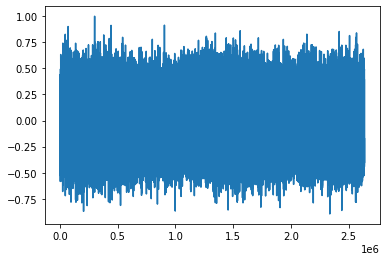

In [75]:
plt.plot(x);

In [76]:
Audio(x, rate=fs)

Output hidden; open in https://colab.research.google.com to view.

Creo mi filtro adaptativo

In [77]:
adapt_filter = AdaptativeFilter(filter_size,mu=1e-2, mu_max=1e-1, mu_min=1e-10, m0_per=1, m1_per=1, alpha=1.1, delta=1e-15)

A partir del siguiente diagrama, procedo a realizar el camino correspondiente.

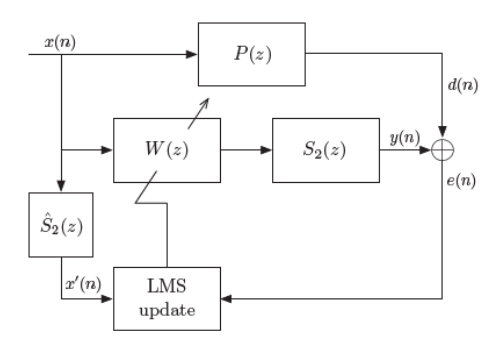

Primero obtengo la señal deseada

In [78]:
desired = p.applyFilter(x)

Despues obtengo la señal $x'(n)$

In [79]:
x_prim = s2_estimation.applyFilterFull(x)

In [80]:
w_out = list(np.zeros(filter_size))
xp_vector = list(np.zeros(filter_size))
error = []
y = []

Simulo tap a tap el sistema:

In [81]:
for i in tqdm(range(len(x))):
	inp = x[i]
	d = desired[i]
	xp = x_prim[i]
	xp_vector.append(xp)
	xp_vector.pop(0)

	w_out.append(adapt_filter.applyFilterToTap(inp))
	w_out.pop(0)

	#temp = apply_filter(w_out, s2)
	temp = s2.applyFilter(w_out)
	y_n = temp[filter_size - 1]
	error_mic = d + y_n
	if i <= 48000*7:
		adapt_filter.fitFilterWithErrorTap(xp_vector, -error_mic)
	error.append(error_mic)
	y.append(y_n)

### Resultados

El mu final fue de:  0.01


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  


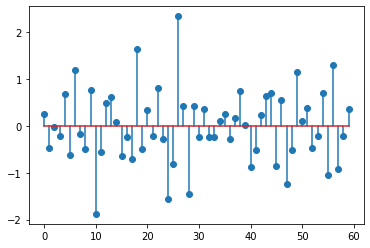

In [82]:
print("El mu final fue de: ", adapt_filter.getMu())
plt.stem(adapt_filter.getFilterParameters());

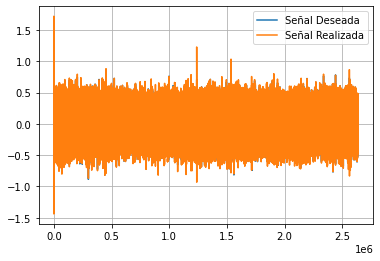

In [83]:
plt.plot(-1*desired[0:len(y)],label= "Señal Deseada");
plt.plot(y,label= "Señal Realizada");
plt.grid(which= "both");
plt.legend();

Si se realiza mas Zoom, se puede ver como el algoritmo adaptativo se ajusto adecuadamente a la entrada.

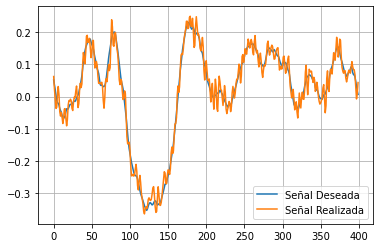

In [84]:
plt.plot(-1*desired[len(y)//2:len(y)//2+400],label= "Señal Deseada");
plt.plot(y[len(y)//2:len(y)//2+400],label= "Señal Realizada");
plt.grid(which= "both");
plt.legend();

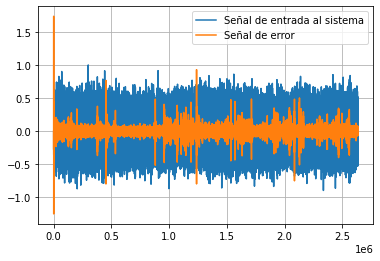

In [85]:
plt.plot(x,label= "Señal de entrada al sistema")
plt.plot(error, label= "Señal de error")
plt.grid(which= "both");
plt.legend();

Acá se puede escuchar la salida de nuestro sistema, es decir, lo que escucharíamos si tuvieramos estos hipotéticos auriculares puestos.

In [86]:
Audio(error, rate=fs)

Output hidden; open in https://colab.research.google.com to view.

In [25]:
#wav.write("/content/drive/Shared drives/PASA/TP LMS/out.wav", fs, np.array(np.array(error) * 2.0 ** 15, dtype='int16'))